# Logistic Regression as a Nerual Network

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py
from time import time

## Introduction

This notebook walks you through the working mechanism of **`Logistic Regression`** as a simple **`Neural Network`**.

In this notebook, I will show you how to build a Logistic Regression model **from scratch** without using scikit-learn. Then, we will use our model to perform a **binary image classification** task: cat or non-cat.

I will also explain in details the **image data** we are using in this notebook and walk you through the **preprocessing** of the images. The **techniques and workflow** used in this notebook can be **easily replicated and applied** to similar image classification tasks.

## Import Data

The data used in this notebook consists of **209 training samples $X_{train}$** and **50 test samples $X_{test}$**.

Each sample is a **colored image** of either a cat or not a cat. Let me show you an example of each class:

<div>
<img src="Images/2.png" width="400"/>
</div>

Each image is stored as a **3D matrix of size 64$*$64$*$3**. This means:

1. the **resolution** of the images is **64$*$64 pixels**
2. the images are **colored** with **3 RGB colors**

As shown below, each 3D matrix consists of **3 layers** corrseponding to the **3 colors** (red, green, blue). The **values** stored in the matrix are the **"strength" of the colors** (ranging from 0-255). By **mixing the 3 colors** of different "strengths", we obtain the color of a specific pixel shown in the image.

<div>
<img src="Images/3.png\" width="600"/>
</div>

Now, let's **import the datasets** into our notebook. 

Since the data are stored as **H5 (Hierarchical Data Format 5) files**, we used a **helper function** to load the datasets.

In [82]:
def load_dataset():
    '''
    Function used to load the datasets which are stored as h5 files.
    '''
    #load the training set
    train_dataset = h5py.File('Data/train_catvnoncat.h5', "r")
    X_train = np.array(train_dataset["train_set_x"][:])
    y_train = np.array(train_dataset["train_set_y"][:])
    y_train = y_train.reshape((1, y_train.shape[0]))
    #load the test set
    test_dataset = h5py.File('Data/test_catvnoncat.h5', "r")
    X_test = np.array(test_dataset["test_set_x"][:]) 
    y_test = np.array(test_dataset["test_set_y"][:]) 
    y_test = y_test.reshape((1, y_test.shape[0]))
    #obtain the classes correspond to the labels
    classes = np.array(test_dataset["list_classes"][:])
    return X_train, y_train, X_test, y_test, classes

In [83]:
#import the training and test set
X_train, y_train, X_test, y_test, classes = load_dataset()

Once we imported the datasets, the **first thing** to do is to **check their sizes**:

In [84]:
print('Shape of the training samples: ', X_train.shape)
print('Shape of the training labels: ', y_train.shape)
print('Shape of the test samples: ', X_test.shape)
print('Shape of the test labels: ', y_test.shape)
print('Classes: ', classes)

Shape of the training samples:  (209, 64, 64, 3)
Shape of the training labels:  (1, 209)
Shape of the test samples:  (50, 64, 64, 3)
Shape of the test labels:  (1, 50)
Classes:  [b'non-cat' b'cat']


For the **training set**, we have shape (209, 64, 64, 3). This means that there are **209 training samples** and each sample is of **size** 64 $*$ 64 $*$ 3. 

Great! The sizes are the same as we expected.

The following block of codes shows you how to plot the matrices as images (i.e. to visualize the image data).

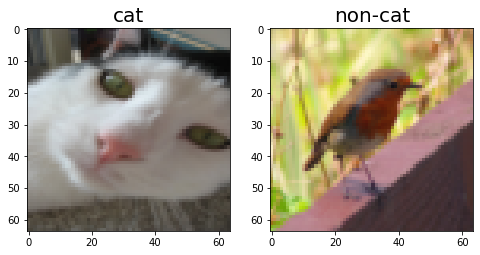

In [75]:
plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.imshow(X_train[14])
plt.title('cat', fontsize=20)

plt.subplot(1,2,2)
plt.imshow(X_train[10])
plt.title('non-cat', fontsize=20)
plt.show()

The next step is to **preprocess** the image data before we can use them to train our models.

## Data Preprocessing

As mentioned above, the image data we have are **3D matrices** of **size** 64 $*$ 64 $*$ 3.

However, **Logistic Regression** can only deal with **1D vectors**. Therefore, we need to **flatten** the image matrices into vectors. This is also known as the **image2vector** technique. To perform **image2vector**, we flatten the **3D matrices** of shape (64, 64, 3) into **1D vectors** of size 64 $*$ 64 $*$ 3. 

In deep learning, we aim to have an **input matrix** of shape ($n$, $m$) where $n$ is the **dimension** and $m$ is the **sample size**:

<div>
<img src="Images/4.png\" width="600"/>
</div>

To flatten the **original input matrix** of shape ($m$, 64, 64, 3) to the **horizontally stacked vectors** of shape (64 $*$ 64 $*$ 3, $m$), we can use this trick:

```python
X_flatten = X.reshape(X.shape[0], -1).T
```

After flattening the input matrix, another common preprocessing step is **standardization**. 

Since the **values** in the input matrix ranges from **0 to 255** ("strength" of colors), a **simplified standardization** for colored image data is to just **divide every element by 255** (the maximum value).

The following **helper function** performs both flattening and standardization:

In [85]:
def preprocess_images(X):
    '''
    Function to perform the imagetovector and standardization.
    '''
    X = X.reshape(X.shape[0], -1).T         #flatten the images
    X = X / 255                             #standardize the data
    return X

In [87]:
X_train = preprocess_images(X_train)
X_test = preprocess_images(X_test)

In [88]:
print('Shape of the input matrix after flattening: ', X_train.shape)

Shape of the input matrix after flattening:  (12288, 209)


## How does Logistic Regression work?

**`Logistic Regression`** has two learnable parameters: **weights** and **bias**.

<div>
<img src="Images/5.png\" width="650"/>
</div>

It computes the **linear regression outputs** ($Z$) with weights and bias. Then, it applies a **sigmoid function** to map the $z$ values into the range $[0,1]$ so that the **final outputs** ($A$) are the **probabilities** of having $y=1$. This is demonstrated as following:

<div>
<img src="Images/6.png\" width="600"/>
</div>

This **prediction process** can be expressed using a **computation graph**:

<div>
<img src="Images/1.png\" width="600"/>
</div>

Looking at the above graph, we will soon realize that **Logistic Regression** is just a **single-layer Neural Network**! 

Now, we just have to find the **optimal values** for the **weights** and **bias** top make the best predictions. We achieve this by **`gradient descent`**.

## Gradient Descent

**`Gradient descent`** is an **optimization method** widely used in machine learning algorithms.

To implement gradient descent, we first need to define a **cost function** that evaluates our predictions. A commonly used cost function for **logistic regression** is based on the **`log-loss`**:

<div>
<img src="Images/7.png\" width="600"/>
</div>

The cost function tells us how much our predictions deviate from the true labels. Smaller the cost function, better the predictions.

Thus, our goal is to **minimize** this cost function $J(y,\hat{y})$. The **weights** and **bias** that give the **minimal** $J(y,\hat{y})$ will then be the **optimal values** we desired.

The gradient indicates the **increasing direction** of a function. Therefore, as long as we are moving in the **opposite direction** to the gradient, we are approaching the **minimum** of the function. Base on this, **gradient descent** is given as following:

<div>
<img src="Images/8.png\" width="600"/>
</div>

We repeat the above process untill **convergence** (i.e. the decrease in the cost function is small enough to be ignored).

Great! We now have a method to find the optimal **weights** and **bias**. The next step is to figure out how to compute the **derivatives**.

## Back Propagation

In **deep learning**, the most commonly used method to compute derivatives is called **`back propagation`**.

Let's first have a look at what the **forward propagation** is like for Logistic Regression:

<div>
<img src="Images/9.png\" width="600"/>
</div>

We record the output matrices $A$ during **forward propagation** and use it to compute the **derivatives** in **back propagation**:

<div>
<img src="Images/10.png\" width="600"/>
</div>

**Back propagation** is the key method used to compute the derivatives in **Neural Networks**. 

Now we have everything! We can now start coding out the Logistic Regression following the steps we discussed above.

## Logistic Regression

In the following block of codes, we defines a **class** which implements Logistic Regression:

In [111]:
class LogisticRegression:
    
    def __init__(self, X_train, y_train, X_test, y_test, learning_rate, n_iter, threshold):
        #initialize the datasets
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        #initialize the shapes
        self.n = X_train.shape[0]
        self.m_train = X_train.shape[1]
        self.m_test = X_test.shape[1]
        #initialize the hyperparameters
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.threshold = threshold
        #initialize the learnable parameters
        self.w = np.zeros((self.n,1))
        self.b = 0.0
        #initialize the cost matrix
        self.J = np.zeros((1,n_iter))
        
    
    def log_loss(self, y_true, y_pred):
        '''
        Function to compute the log loss over the predicted probabilities.
        '''
        m = len(y_true)                                                #number of samples
        L = y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred)        #loss on each sample
        J = -np.sum(L) / m                                             #the overall cost
        return L, J
    
    
    def accuracy(self, y_true, y_pred):
        '''
        Function to compute the accuracy of the predictions.
        '''
        accuracy = np.sum(y_true==y_pred) / y_true.shape[1]            
        return accuracy
        
    
    def forward_propagate(self, X, y):
        '''
        Function to perform a single forward propagation.
        '''
        m = X.shape[1]                             #size of the training set
        z = np.dot(self.w.T, X) + self.b           #linear regression
        A = 1 / (1 + np.exp(-z))                   #sigmoid function
        L, J = self.log_loss(y, A)                 #compute the log loss and cost
        return J, A
        
        
    def back_propagate(self, X, y):
        '''
        Function to perform a single ckward propagation.
        '''
        m = X.shape[1]                             #size of the training set
        J, A = self.forward_propagate(X, y)        #perform forward propagation
        dz = A - y                                 #compute the derivative of the cost function to z (dJ/dz)
        dw = np.dot(X, dz.T) / m                   #compute the derivative of the cost function to the weights (dJ/dw)
        db = np.sum(dz) / m                        #compute the derivative of the cost function to the bias (dJ/db)
        return dw, db, J
        
    
    def train(self):
        '''
        Function to train the model with gradient descent over the training set.
        '''
        start = time()
        for i in range(n_iter):
            dw, db, J = self.back_propagate(self.X_train, self.y_train)     #perform back propagation
            self.w -= self.learning_rate * dw                               #a single step of gradient descent on weights
            self.b -= self.learning_rate * db                               #a single step of gradient descent on bias
            self.J[0,i] = J                                                 #store the cost at this point
        end = time()
        print(f'Model successfully trained over {n_iter} iterations using {round(end-start, 3)} seconds.')
        

    def predict(self):
        '''
        Function to make predictions on both the training and test sets,
        and compute the training and test error rates.
        '''
        #make predictions on the training set and compute the training error
        _, A_train = self.forward_propagate(self.X_train, self.y_train)
        y_pred_train = A_train.copy()
        y_pred_train[y_pred_train>=self.threshold] = 1          #compares the predicted probabilities to the threshold
        y_pred_train[y_pred_train<self.threshold] = 0
        train_error = 1 - self.accuracy(self.y_train, y_pred_train)
        #make predictions on the test set and compute the test error
        _, A_test = self.forward_propagate(self.X_test, self.y_test)
        y_pred_test = A_test.copy()
        y_pred_test[y_pred_test>=self.threshold] = 1
        y_pred_test[y_pred_test<self.threshold] = 0      
        test_error = 1 - self.accuracy(self.y_test, y_pred_test)
        return y_pred_train, train_error, y_pred_test, test_error

## Train the Model

Now, we can start the **modelling** process!

In [112]:
#we first initialize the parameters
n_iter = 600
threshold = 0.5
learning_rate = 0.01

#we need to create a logistic regression model
lr = LogisticRegression(X_train, y_train, X_test, y_test, learning_rate, n_iter, threshold)

#then, we train the model
lr.train()

Model successfully trained over 600 iterations using 0.891 seconds.


Let's visualize the **convergence** of the cost during gradient descent:

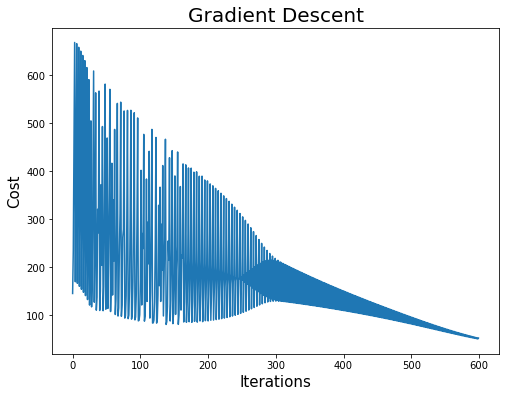

In [113]:
plt.figure(figsize=(8,6))
plt.plot(lr.J[0])
plt.title('Gradient Descent', fontsize=20)
plt.ylabel('Cost', fontsize=15)
plt.xlabel('Iterations', fontsize=15)
plt.show()

Nice! The above diagram tells us that our model **has converged** and therefore the **weights** and **bias** are now optimized.

## Make Predictions

The next step is to **make predictions** using our model:

In [114]:
y_pred_train, train_error, y_pred_test, test_error = lr.predict()

print(f'Training error: {100*round(train_error,4)}%')
print(f'Test error: {100*round(test_error,4)}%')

Training error: 9.09%
Test error: 22.0%


Here we observed a low training error and a **high test error** indicating our model is **slightly overfitted**. 

Let's have a look as some examples in the **test set** and see how our model do:

y = 0, you predicted that it is a "non-cat" picture.


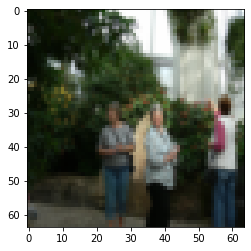

y = 0, you predicted that it is a "non-cat" picture.


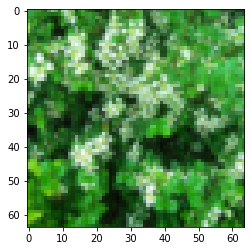

y = 1, you predicted that it is a "cat" picture.


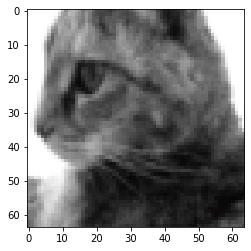

y = 1, you predicted that it is a "cat" picture.


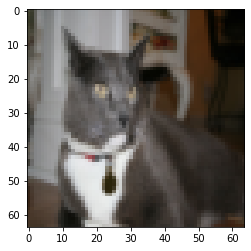

y = 1, you predicted that it is a "cat" picture.


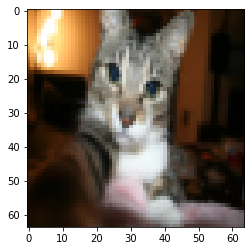

In [110]:
for index in range(21, 26):
    print ("y = " + str(y_test[0,index]) + ", you predicted that it is a \"" + classes[int(y_pred_test[0,index])].decode("utf-8") +  "\" picture.")
    plt.imshow(X_test[:, index].reshape((64, 64, 3)))
    plt.show()

Great! As least the model correctly identified all of the above five examples (both cat and non-cat).

This is the end of the notebook. You should now be able to build a **Logistic Regression** (as a **Neural Network**) from scratch.